In [71]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/hpc-rosneft/drigo/surrogate/src/')
from main import Main
import numpy as np
import netCDF4 as nc

import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from dataset import load_features, load, load_variable_years


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def plot(pred):
    cmap=plt.get_cmap('rainbow')
    cmap.set_bad('white')
    plt.title('Prediction')
    plt.imshow(pred, cmap=cmap)

def mapping(data):
    m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='i')
    xi, yi = m(lons, lats)

    #m.drawparallels(np.arange(-80.,81.,20.), linewidth=0.8)
    #m.drawmeridians(np.arange(-180.,181.,20.), linewidth=0.8)
    # Add Coastlines, States, and Country Boundaries
    #m.drawlsmask(land_color='c', ocean_color='w', lsmask=None)
    m.fillcontinents()
    m.drawmapboundary(fill_color='white')
    m.drawcountries()

    #cmp = cm.get_cmap('rainbow', 11)
    cmap=plt.get_cmap('rainbow')
    cmap.set_bad('white')
    cmesh = m.pcolormesh(xi, yi, data, cmap=cmap,alpha=1, edgecolors='none')
    cb = m.colorbar(cmesh, location='bottom', label="Sea ice thickness")
    cb.set_ticks([1, 2, 3, 4])

def map_multiply(pred,sattelite, climatology):

    plt.subplot(1, 3, 1)
    plt.title('Prediction')
    mapping(pred)

    plt.subplot(1, 3, 2)
    plt.title('Sattelite')
    mapping(sattelite)
    
    plt.subplot(1, 3, 3)
    plt.title('Climatology mean')
    mapping(climatology)
    plt.show()

## Regression parameters:

**PARAMETERS**
- years_train : [2010, 2011, 2012, 2013]
- years_test : [2014, 2015]
- X_vars : ['ice_conc', 'tair', 'votemper', 'vosaline']
- y_var : thick_cr2smos
- bounds : [0, 400, 0, 400]
- step : [5, 5]

**REGRESSION PARAMETERS**
- model : Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
- dx : 2
- dy : 2
- dt : 10

In [39]:
data = np.load('data/results/res_0521_1357.npy',allow_pickle=True)
climatology = np.load('data/mean_thick_2010-2015.npy')
sattelite = load_variable_years('thick_cr2smos', [2014, 2015])

lats = np.load('data/lats.npy')
lons = np.load('data/lons.npy')

nyears = d.shape[0]//365
climatology = np.repeat(climatology, nyears, axis=0)

In [40]:
def mean3d(data):
    return np.nanmean(data,axis=(1,2))

def rmse3d(pred, test):
    assert np.shape(pred)==np.shape(test), 'Prediction and test data should be same shape'
    rmse=np.sqrt(mean3d(pred.data-test)**2)
    #rmse = np.sqrt(np.nanmean((test - pred)**2))
    #todo - дописать как в статье
    return rmse

In [41]:
rmse_data_climatology = rmse3d(data, climatology)
rmse_climatology_sattelite = rmse3d(sattelite, climatology)
rmse_data_sattelite = rmse3d(data, sattelite)

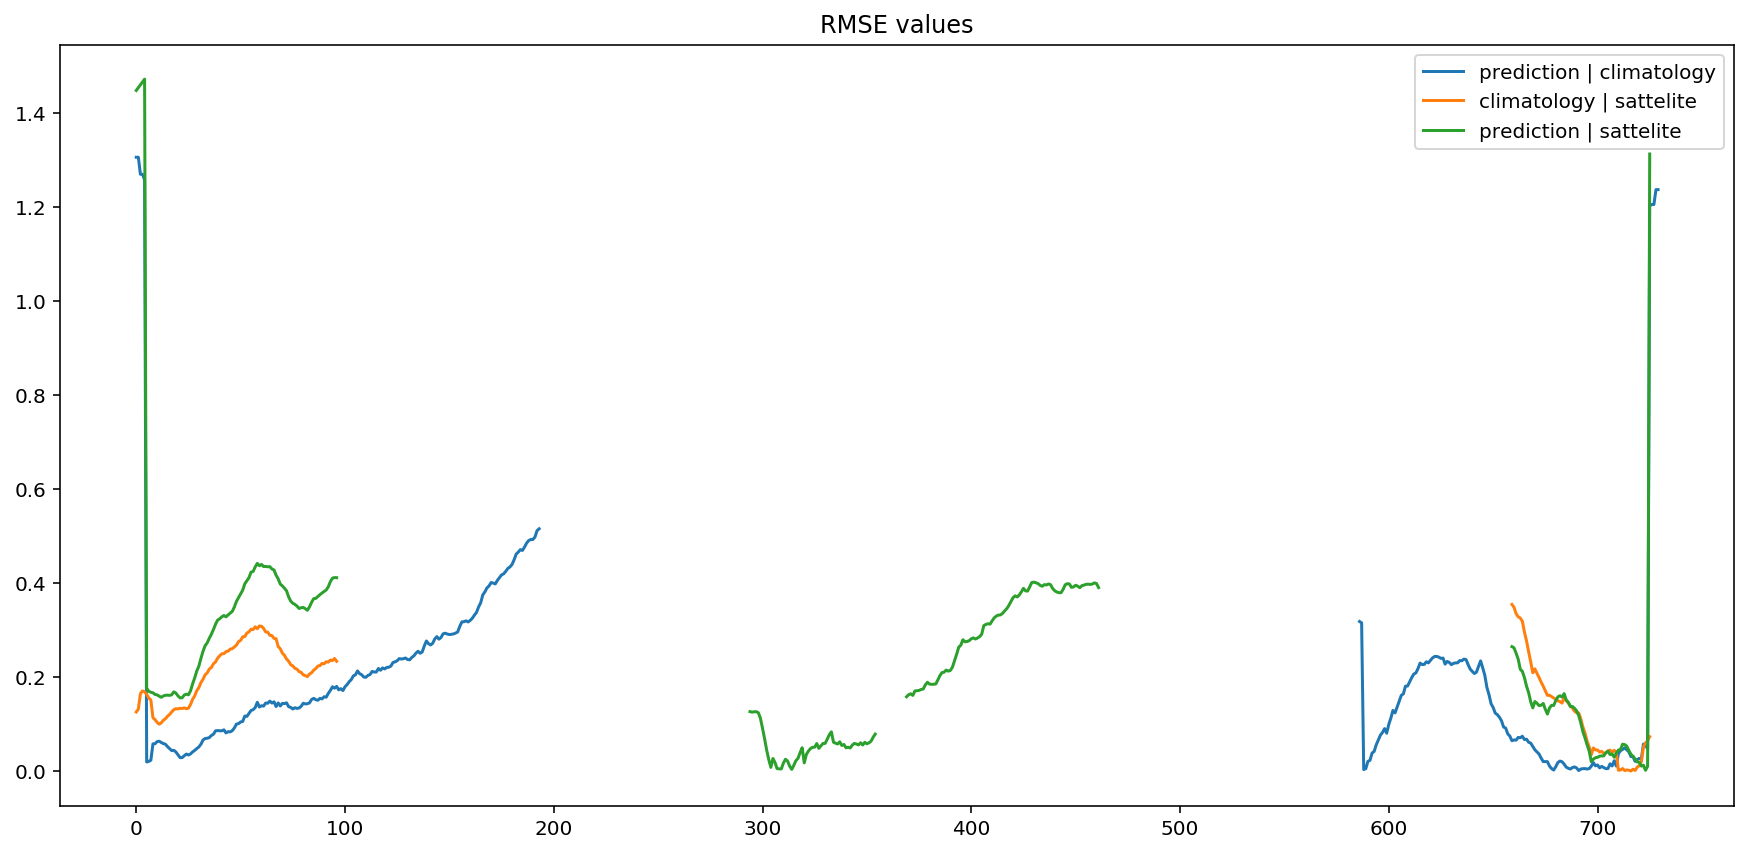

In [44]:
plt.plot(rmse_data_climatology, label='prediction | climatology')
plt.plot(rmse_climatology_sattelite, label='climatology | sattelite')
plt.plot(rmse_data_sattelite, label='prediction | sattelite')
plt.title('RMSE values')
plt.legend()
plt.show()

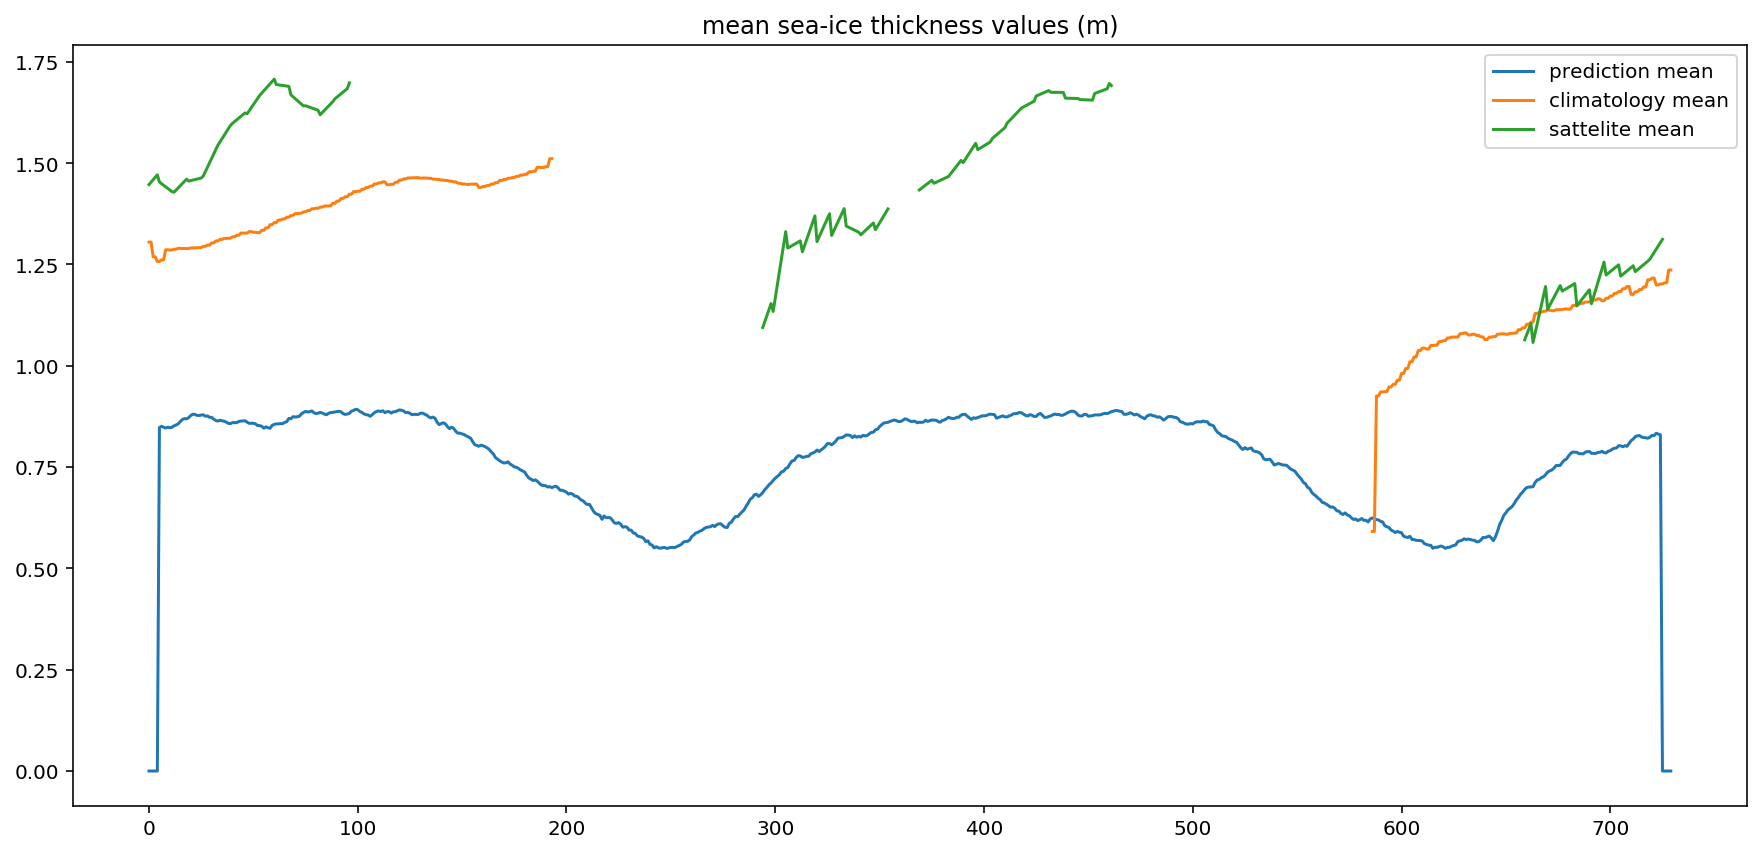

In [47]:
plt.plot(mean3d(data), label = 'prediction mean')
plt.plot(mean3d(climatology), label = 'climatology mean')
plt.plot(mean3d(sattelite), label = 'sattelite mean')
plt.title('mean sea-ice thickness values (m)')
plt.legend()
plt.show()

/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/hpc-rosneft/anaconda3/envs/drigo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


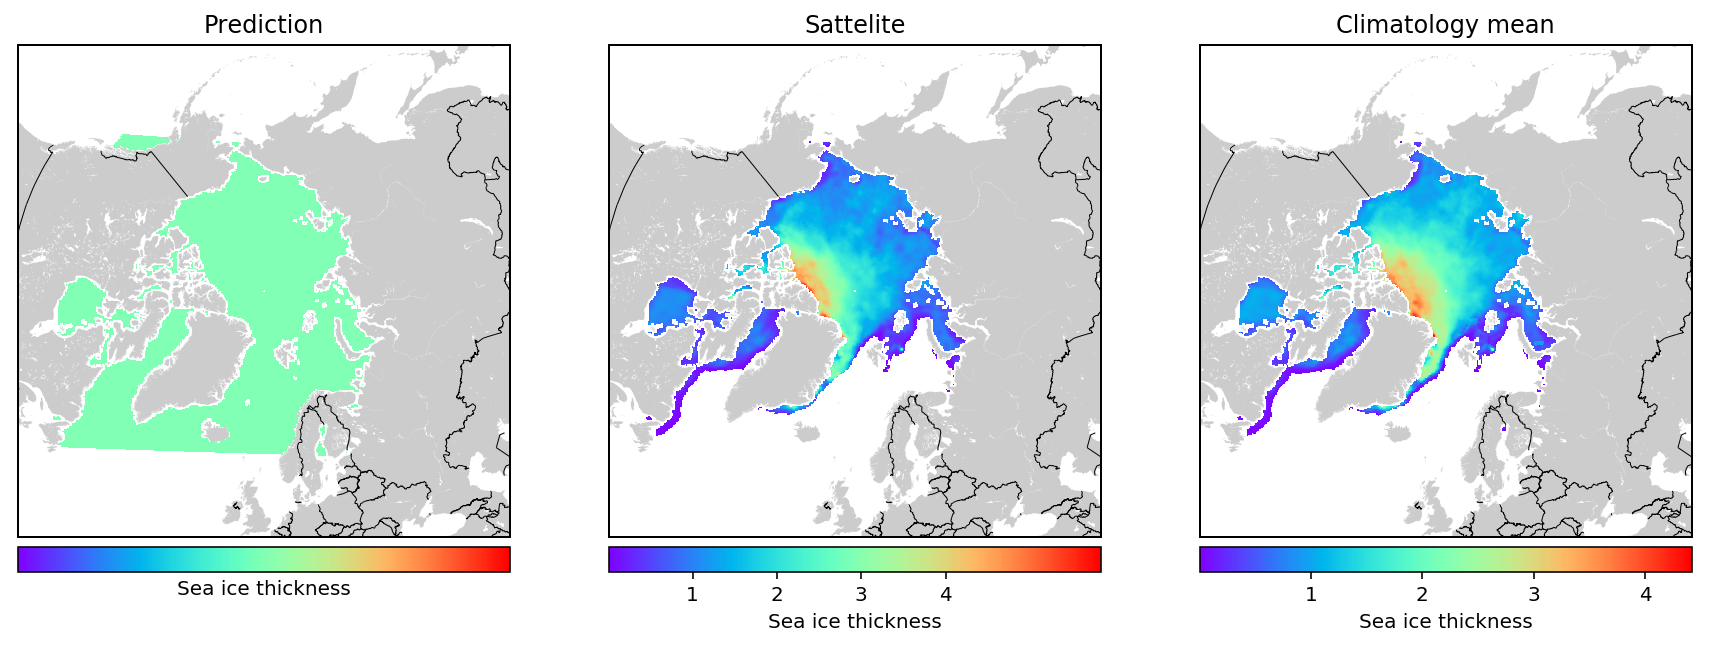

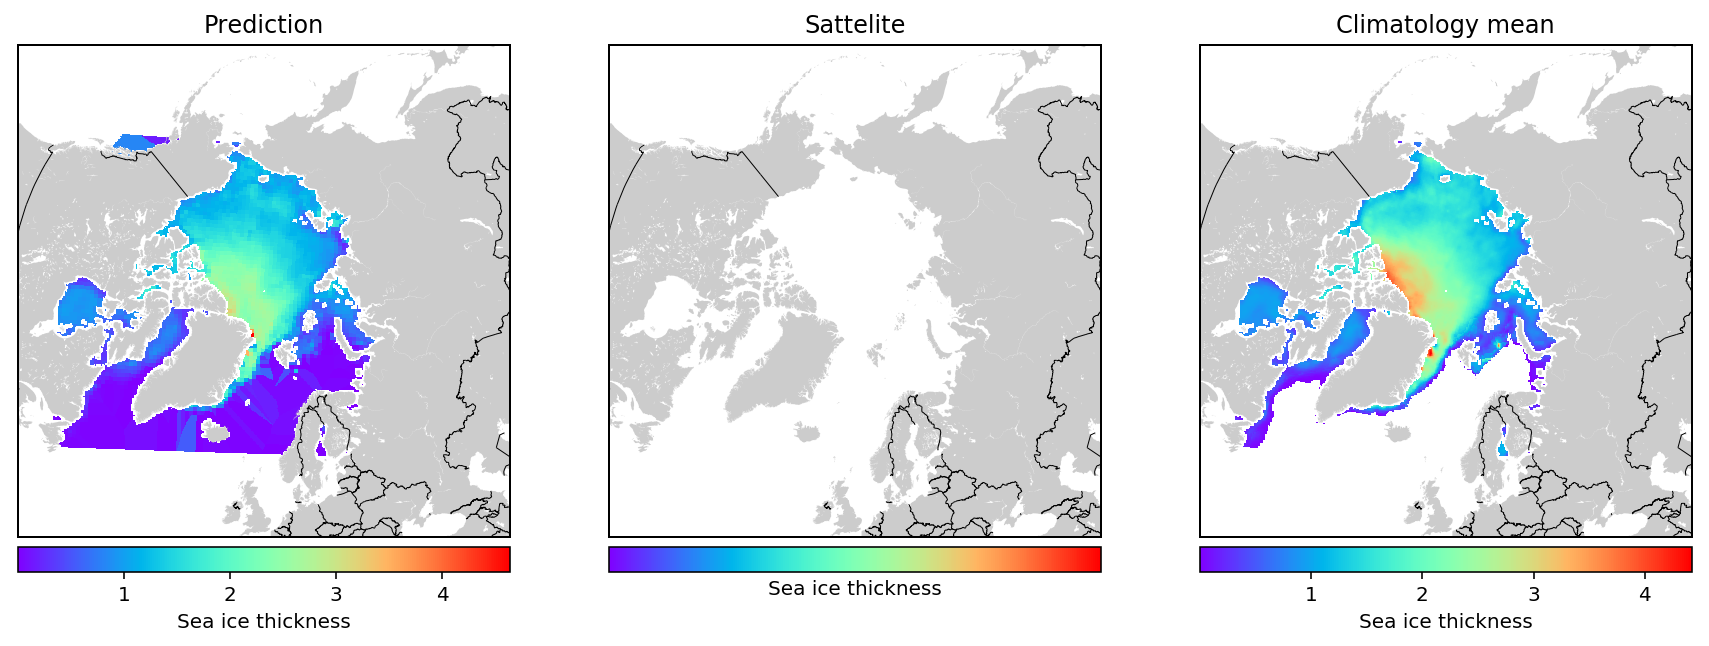

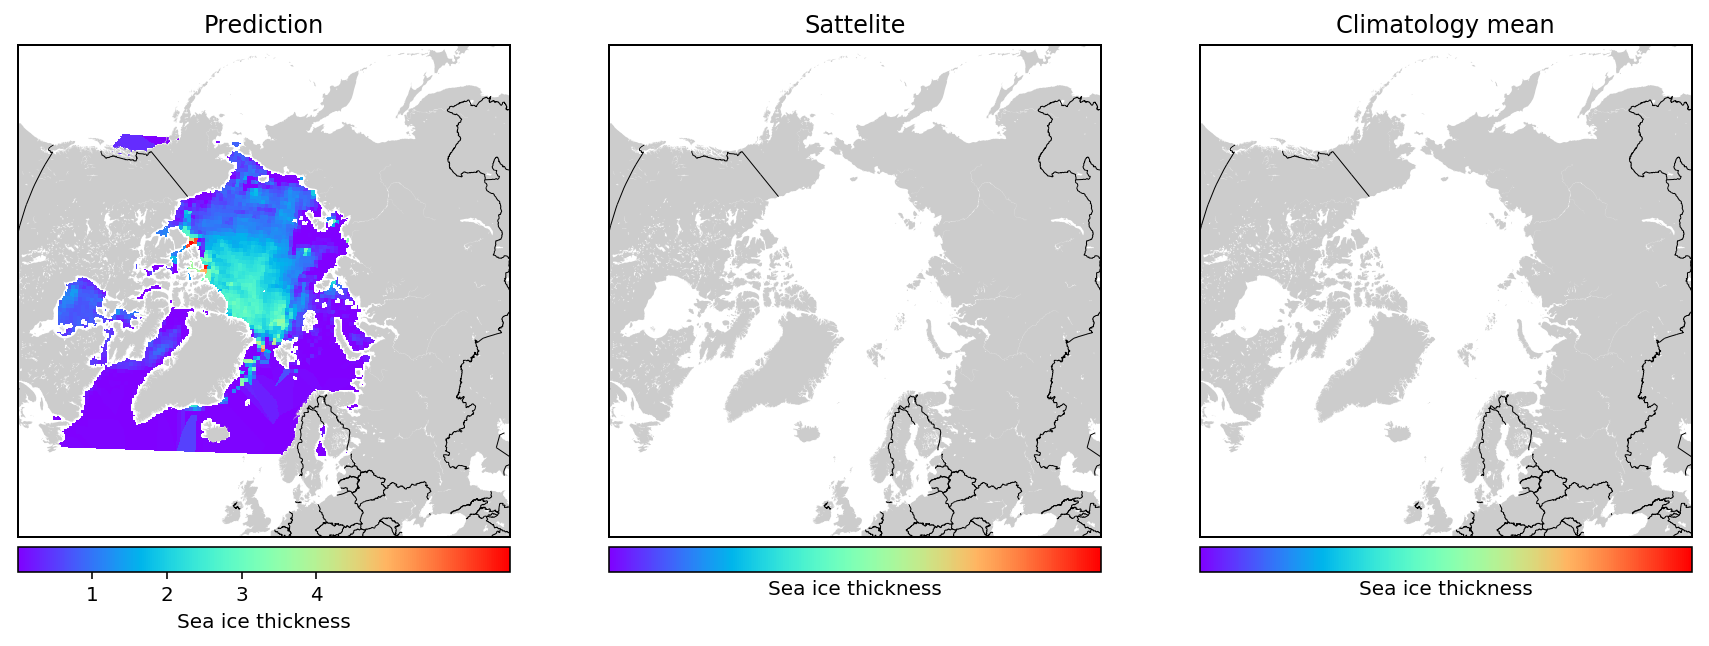

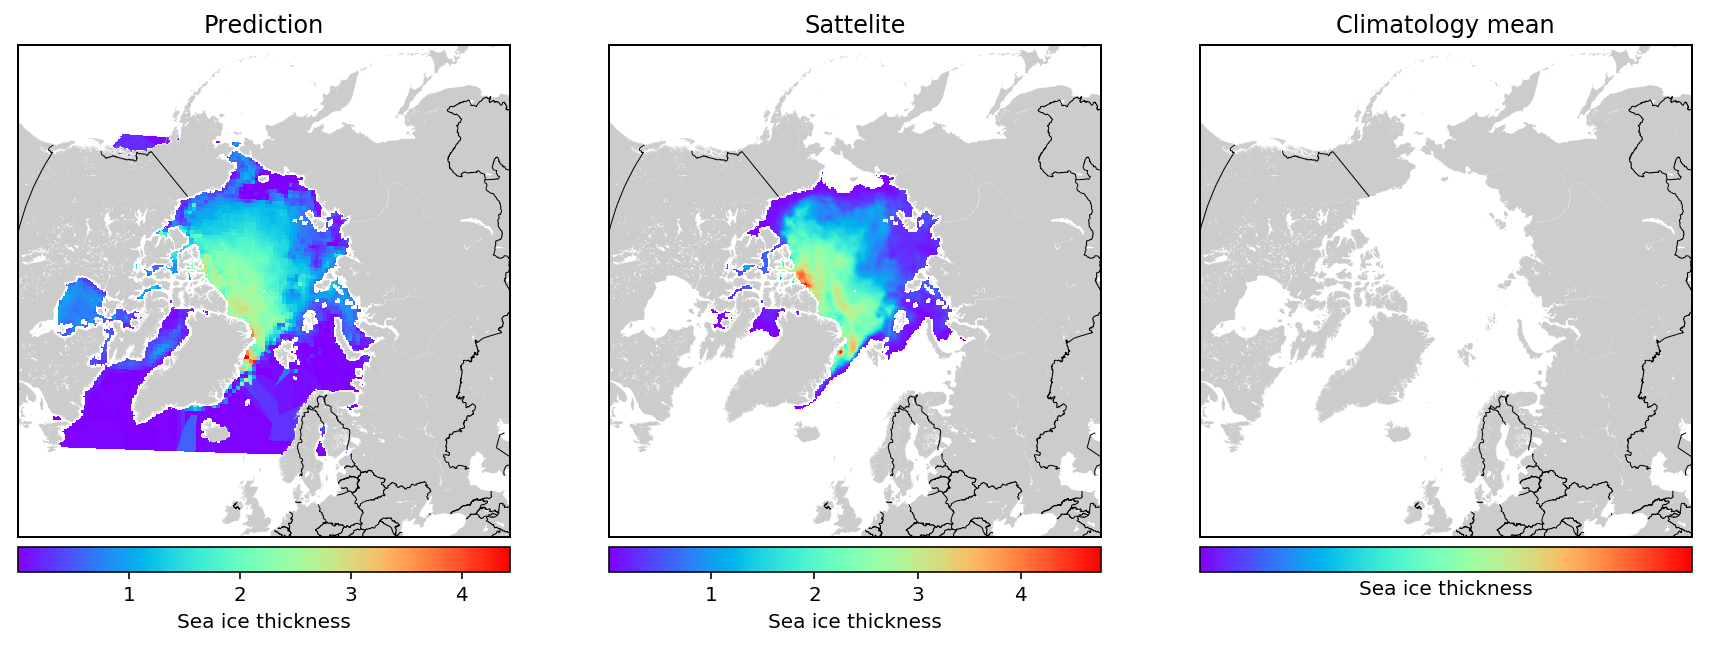

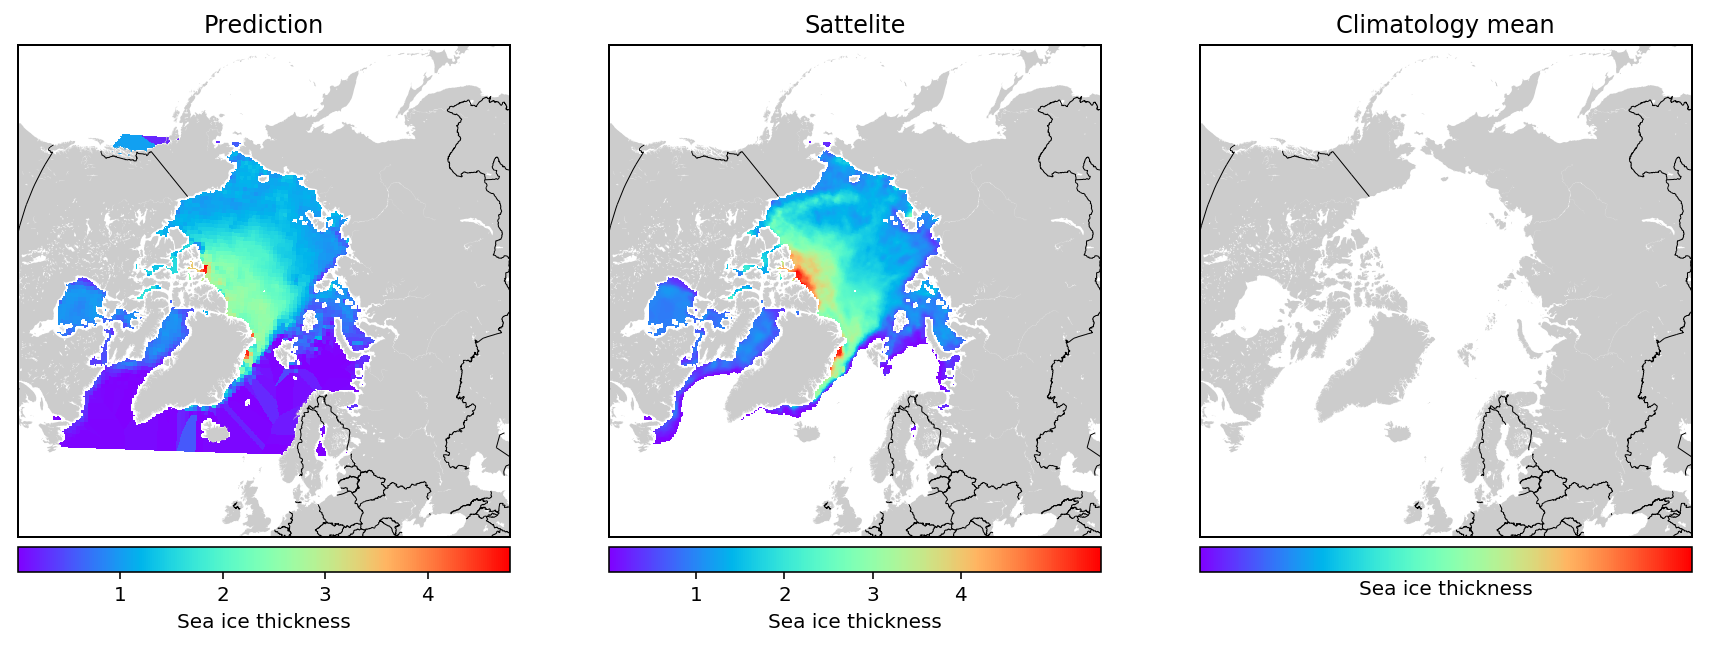

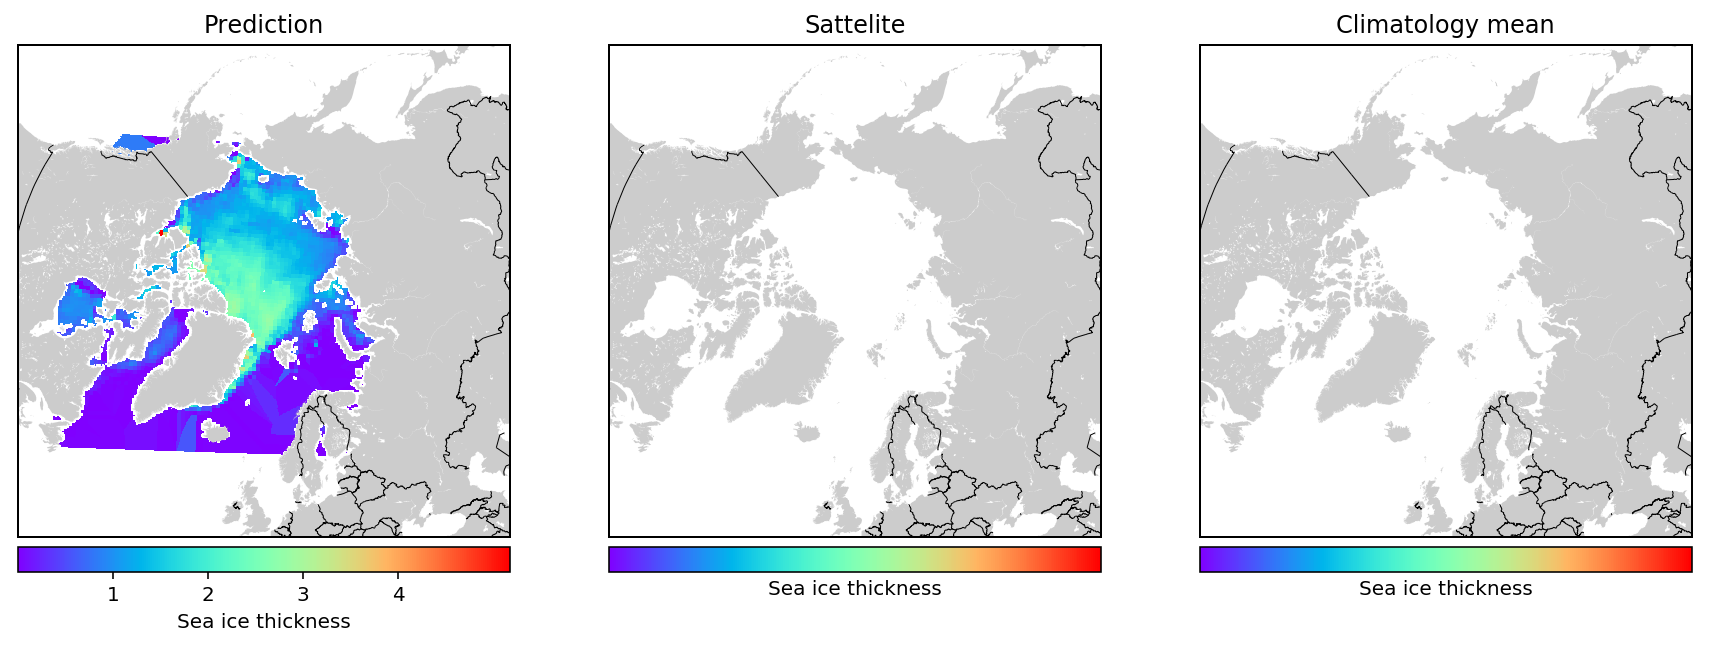

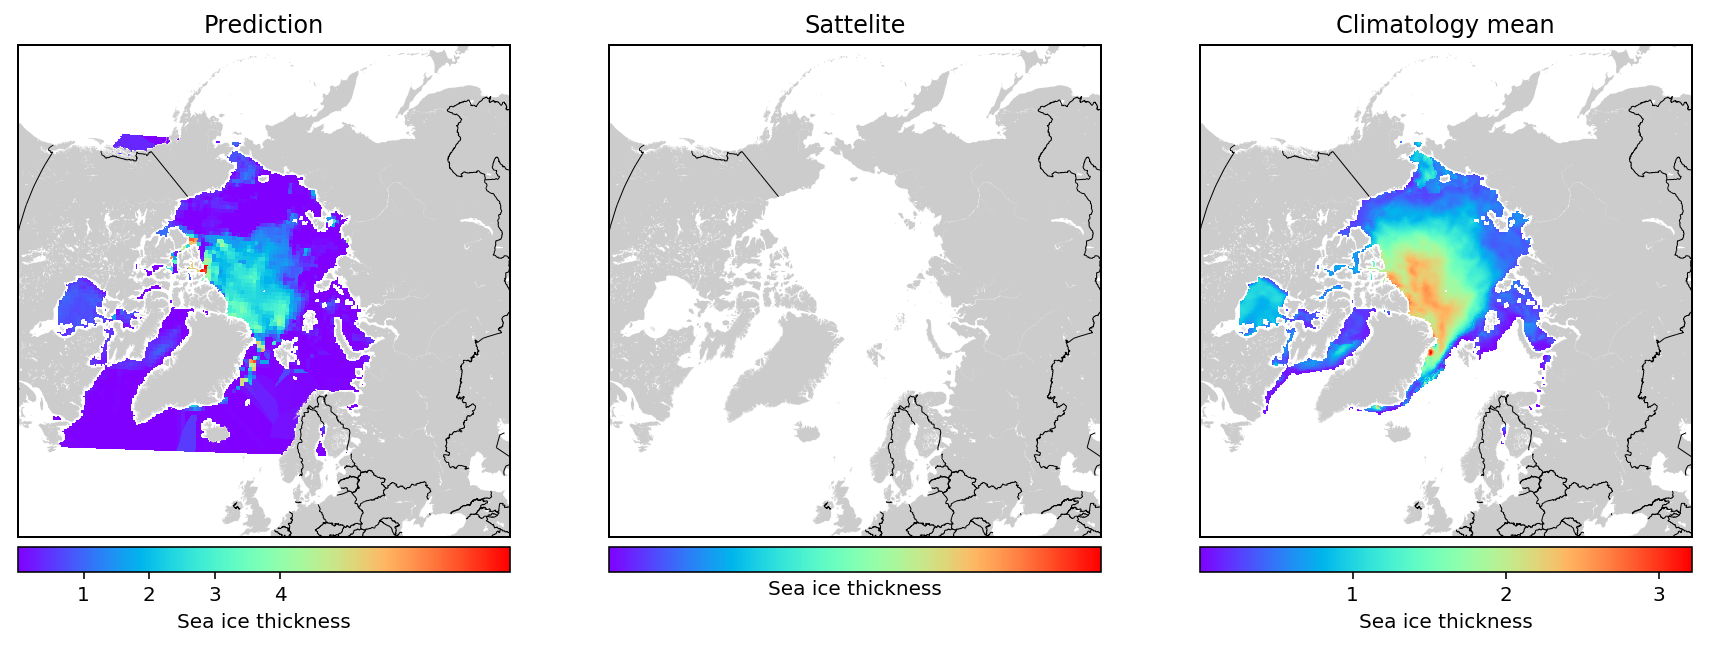

In [76]:
tsteps = [0,100,200,300,400,500,600]

for t in tsteps:
    map_multiply(data[t,:,:],sattelite[t,:,:],climatology[t,:,:])